In [4]:
import os, sys
from pathlib import Path
base_path = Path(os.getcwd())
if not (base_path / 'code').exists():
    base_path = Path(os.getcwd()) / '../../'
    base_path = base_path.resolve()
    os.chdir(base_path)
print(base_path)
sys.path.append(str(base_path / 'code/calib'))
sys.path.append(str(base_path / 'code'))
sys.path.append(str(base_path / 'modules'))
from data_loader import mixed_loader
from pred import load_predictor
from eval_detection.utils import *
from misc import misc

/home/francescoa98/workspace/thesis


In [5]:
from projections import mappings as mp

In [6]:
config_path = Path(base_path / 'params/caldet.yaml')

In [7]:
from ruamel import yaml

config = 'params/caldet.yaml'

params = yaml.safe_load(open(config_path))
args = misc.Tupperware(params)

In [8]:
ds = mixed_loader.MixedDataset(
        data_path=args.dataset_dir,
        path_file=args.train_file,
        is_train=False,
        config=args
    )

In [9]:
inputs = ds.__getitem__(0)

In [10]:
inputs.keys()

dict_keys(['file', 'des', 'color', 'img', 'valid_mask', 'va_vec', 'metadata'])

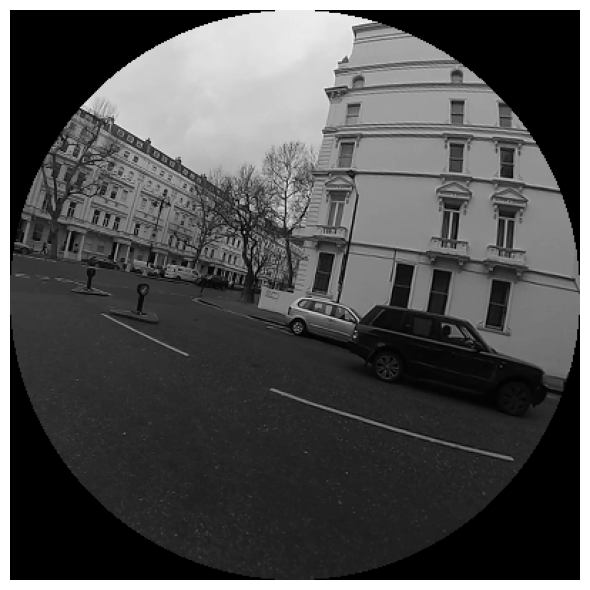

In [11]:
plot_imgs([t2np(inputs['img'], has_batch=False)],cmap='gray' )

In [12]:
des = inputs['des']
des.extrinsic_rot = (0,0,0)

In [13]:
va_vec = des.get_va_vector()

In [14]:
out_des = mp.Perspective_Description(600,600,intrinsics={'afov':100})

In [15]:
img_out = mp.map_img(t2np(inputs['img'], has_batch=False), [des,out_des])[0]

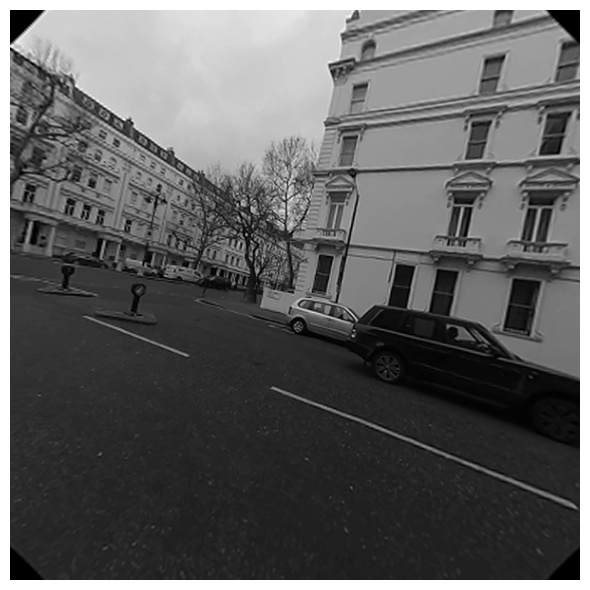

In [16]:
plot_imgs([img_out],cmap='gray' )

In [17]:
from projections import calibration as cal

In [18]:
va_vec.shape

(200,)

In [19]:
def sample_va_vec(va_vec:np.ndarray, cell_size = 8):
    start = cell_size // 2
    idxs = np.arange(start, va_vec.shape[0], cell_size)
    vals = va_vec[idxs]
    return vals, idxs

In [20]:
va_s, rhos = sample_va_vec(va_vec, 40)

In [21]:
va_s.shape

(5,)

In [22]:
c = cal.Calibration.from_rho_angles(i_rho=rhos, w_angles=va_s, camera=mp.FisheyeDS_Description)
intr = c.run()

In [23]:
c = cal.Calibration.from_va_vec(va_vec, mp.FisheyeDS_Description)
intr = c.run(method='ls-cauchy')

In [24]:
intr

{'f': 204.3038614462771, 'a': 0.44148949349803107, 'xi': 0.15275278093410383}

In [25]:
des.get_intrinsics()

{'f': 204.30386144622298, 'a': 0.44148949349809474, 'xi': 0.15275278093379963}

In [26]:
des_cal = mp.FisheyeDS_Description(width=des.width, height=des.height, intrinsics=intr)

In [27]:
img_out2 = mp.map_img(t2np(inputs['img'], has_batch=False), [des_cal,out_des])[0]

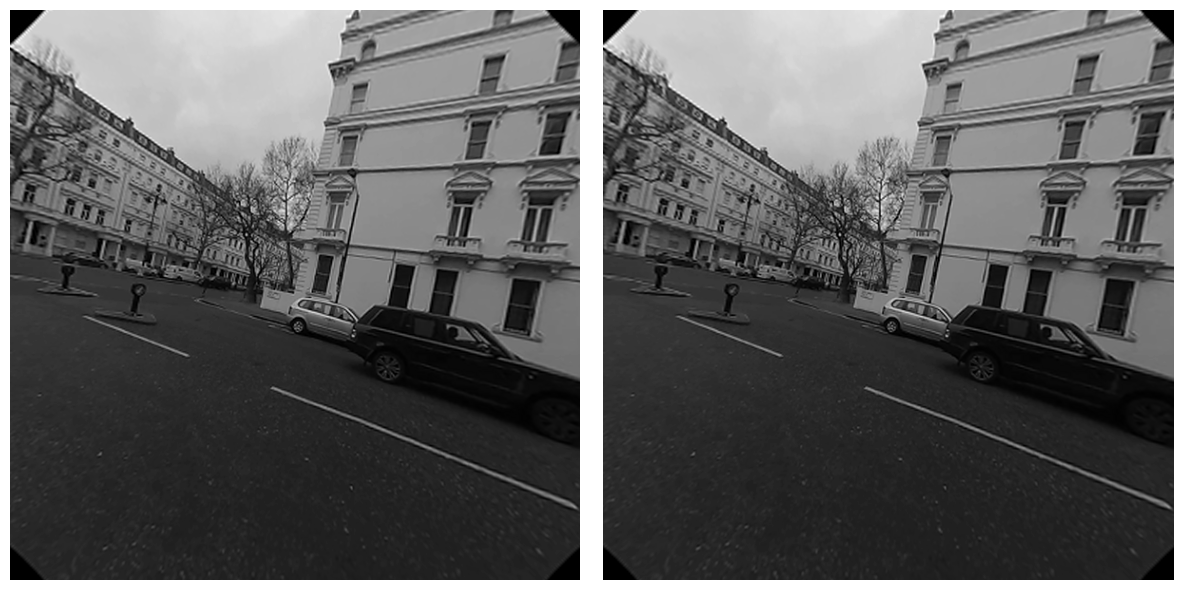

In [28]:
plot_imgs([img_out, img_out2],cmap='gray' )

In [29]:
from metrics.similarity import SSIM

In [30]:
SSIM().evaluate(img_out, img_out2)

1.0

In [31]:
distortion_grid = cv.imread("distortion.png")

In [49]:
in_des = mp.Perspective_Description(distortion_grid.shape[0],distortion_grid.shape[1],intrinsics={'afov':100})
out_des = mp.FisheyeDS_Description(distortion_grid.shape[0],distortion_grid.shape[1],
                                   intrinsics=dict(
                                    f=in_des.f,
                                    a=0.2,
                                    xi=-.4,
                                   ))

In [50]:
distorted = mp.map_img(distortion_grid, [in_des,out_des])[0]

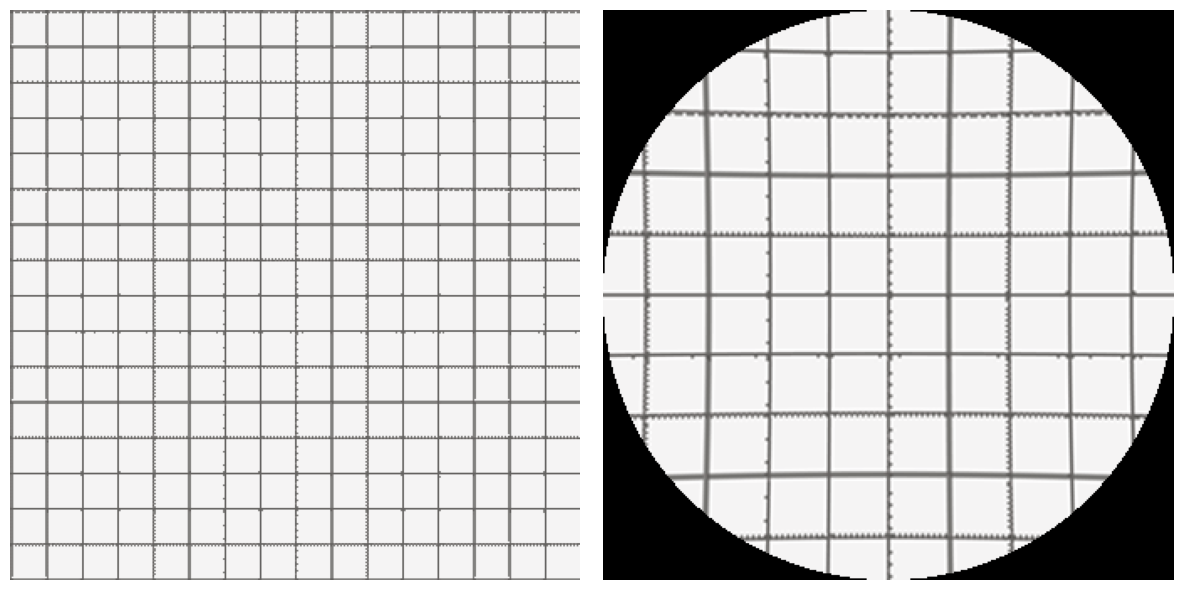

In [51]:
plot_imgs([distortion_grid, distorted])